## Muscimol experiment analyses

In [24]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import npc_lims
from npc_sessions import DynamicRoutingSession
import dynamic_routing_analysis as dra

In [2]:
def load_trials_or_units(session, table_name):
    if table_name == 'trials':
        try:
            table=pd.read_parquet(
                    npc_lims.get_cache_path('trials',session.id,version='any')
                )
            print(session.id,'cached trials loaded')
        except:
            print(session.id,'cached trials not found, loading with npc_sessions')
            try:
                table = session.trials[:]
            except:
                print(session.id,'loading trials failed')
                return None
    elif table_name == 'units':
        try:
            table=pd.read_parquet(
                    npc_lims.get_cache_path('units',session.id,version='any')
                )
            print(session.id,'cached units loaded')
        except:
            print(session.id,'cached units not found, loading with npc_sessions')
            try:
                table = session.units[:]
            except:
                print(session.id,'loading units failed')
                return None
    return table



In [3]:
muscimol_session_id='712141_2024-06-05'
control_session_id='712141_2024-06-06'

muscimol_session = DynamicRoutingSession(muscimol_session_id)
control_session = DynamicRoutingSession(control_session_id)

muscimol_trials=load_trials_or_units(muscimol_session,'trials')
control_trials=load_trials_or_units(control_session,'trials')

muscimol_units=load_trials_or_units(muscimol_session,'units')
control_units=load_trials_or_units(control_session,'units')

712141_2024-06-05 cached trials not found, loading with npc_sessions
712141_2024-06-06 cached trials not found, loading with npc_sessions
712141_2024-06-05 cached units not found, loading with npc_sessions


fetching units: 100%|█████████████████████████| 6/6 [01:41<00:00, 16.94s/device]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  

712141_2024-06-06 cached units not found, loading with npc_sessions


fetching units: 100%|█████████████████████████| 6/6 [01:34<00:00, 15.83s/device]
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  

## plot n units per probe for control and muscimol

Text(0.5, 0.98, 'Muscimol (712141_2024-06-05) vs Control (712141_2024-06-06): Number of Units by Probe')

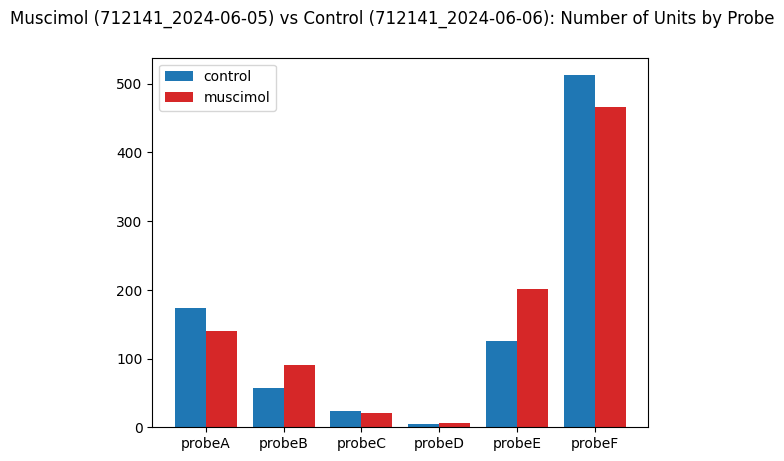

In [90]:
probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

fig,ax=plt.subplots(1,1)

for i,probe_name in enumerate(probe_names):
    
    muscimol_units_probe = muscimol_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = control_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    ax.bar(i-0.2,len(control_units_probe),color='tab:blue',label='muscimol',width=0.4)
    ax.bar(i+0.2,len(muscimol_units_probe),color='tab:red',label='muscimol',width=0.4)

ax.set_xticks(range(6))
ax.set_xticklabels(probe_names)
ax.legend(['control','muscimol'])

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): Number of Units by Probe')

## plot overall average firing rate across probes

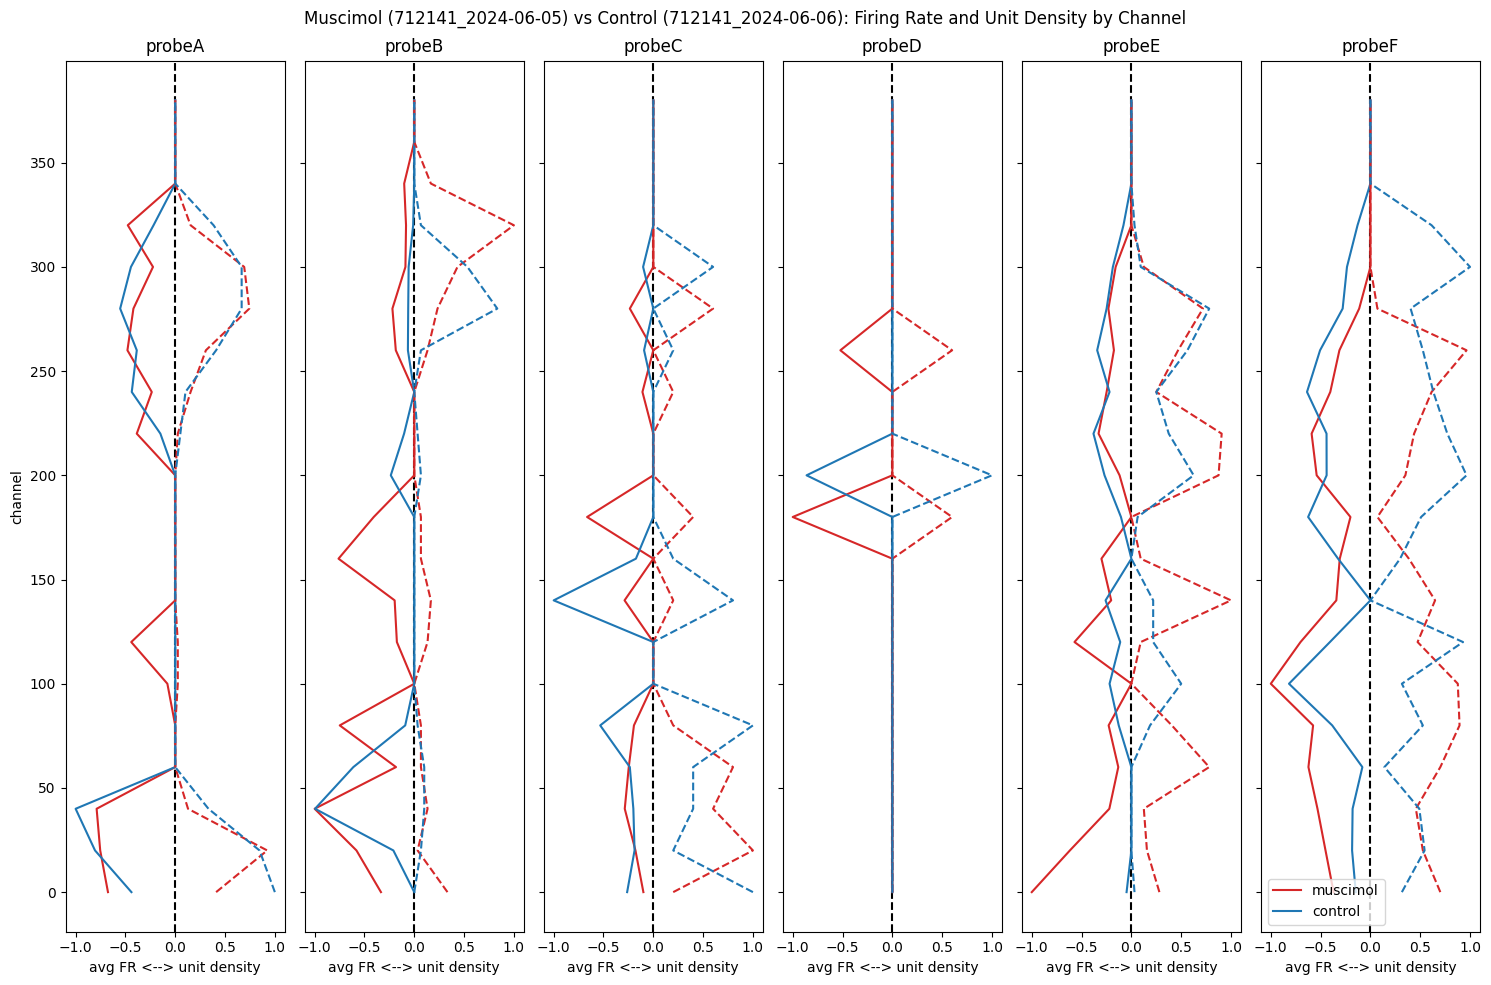

In [57]:
probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

results_by_probe = {
    'probe_name': [],
    'muscimol_fr': [],
    'control_fr': [],
    'muscimol_unit_density': [],
    'control_unit_density': [],
    'fr_max':[],
    'unit_density_max':[],
}

channel_bin_size = 20

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
# probe_name='probeA'
    muscimol_units_probe = muscimol_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = control_units.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    muscimol_probe_frs = []
    control_probe_frs = []
    muscimol_probe_unit_densities = []
    control_probe_unit_densities = []

    for ch in channel_bins:
        muscimol_units_probe_ch = muscimol_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')
        control_units_probe_ch = control_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')

        if len(muscimol_units_probe_ch)==0:
            muscimol_probe_frs.append(0)
            muscimol_probe_unit_densities.append(0)
        elif len(muscimol_units_probe_ch)>0:
            muscimol_probe_frs.append(muscimol_units_probe_ch['firing_rate'].mean())
            muscimol_probe_unit_densities.append(len(muscimol_units_probe_ch))
        
        if len(control_units_probe_ch)==0:
            control_probe_frs.append(0)
            control_probe_unit_densities.append(0)
        elif len(control_units_probe_ch)>0:
            control_probe_frs.append(control_units_probe_ch['firing_rate'].mean())
            control_probe_unit_densities.append(len(control_units_probe_ch))

    results_by_probe['probe_name'].append(probe_name)
    results_by_probe['muscimol_fr'].append(np.array(muscimol_probe_frs))
    results_by_probe['control_fr'].append(np.array(control_probe_frs))
    results_by_probe['muscimol_unit_density'].append(np.array(muscimol_probe_unit_densities))
    results_by_probe['control_unit_density'].append(np.array(control_probe_unit_densities))
    results_by_probe['fr_max'].append(max(np.nanmax(muscimol_probe_frs),np.nanmax(control_probe_frs)))
    results_by_probe['unit_density_max'].append(max(np.nanmax(muscimol_probe_unit_densities),np.nanmax(control_probe_unit_densities)))

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

fig,ax=plt.subplots(1,6,figsize=(15,10),sharey=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].plot(-probe_data['muscimol_fr']/probe_data['fr_max'],channel_bins,label='muscimol',color='tab:red')
    ax[i].plot(-probe_data['control_fr']/probe_data['fr_max'],channel_bins,label='control',color='tab:blue')
    ax[i].plot(probe_data['muscimol_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:red',linestyle='--')
    ax[i].plot(probe_data['control_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:blue',linestyle='--')
    ax[i].set_title(probe_name)
    ax[i].set_xlabel('avg FR <--> unit density')
    if i==5:
        ax[i].legend()
    elif i==0:
        ax[i].set_ylabel('channel')

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): Firing Rate and Unit Density by Channel')
fig.tight_layout()
    

## get single unit modulation info

In [25]:
unit_modulation_control = dra.compute_stim_context_modulation(control_trials, control_units, npc_lims.get_session_info(control_session.id), save_path=None)
unit_modulation_muscimol = dra.compute_stim_context_modulation(muscimol_trials, muscimol_units, npc_lims.get_session_info(muscimol_session.id), save_path=None)

c:\Anaconda3\envs\npc_analysis\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-val

In [39]:
# see all columns
unit_modulation_muscimol.columns.values

array(['amplitude_cutoff', 'amplitude_cv_median', 'amplitude_cv_range',
       'amplitude_median', 'drift_ptp', 'drift_std', 'drift_mad',
       'firing_range', 'firing_rate', 'isi_violations_ratio',
       'isi_violations_count', 'num_spikes', 'presence_ratio',
       'rp_contamination', 'rp_violations', 'sliding_rp_violation', 'snr',
       'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'd_prime',
       'isolation_distance', 'l_ratio', 'silhouette', 'nn_hit_rate',
       'nn_miss_rate', 'exp_decay', 'half_width', 'num_negative_peaks',
       'num_positive_peaks', 'peak_to_valley', 'peak_trough_ratio',
       'recovery_slope', 'repolarization_slope', 'spread',
       'velocity_above', 'velocity_below', 'electrode_group_name',
       'peak_channel', 'cluster_id', 'default_qc', 'amplitude', 'unit_id',
       'peak_electrode', 'obs_intervals', 'electrode_group', 'session_id',
       'project', 'baseline_context_modulation_index',
       'baseline_context_modulation_p_value',
       'ba

### useful metrics:

'vis1_stimulus_modulation_zscore': how much a unit is modulated by vis1, normalized to baseline mean and stdev

'vis1_stimulus_modulation_p_value': is unit significantly modulated by vis1? (Wilcoxon sign-rank test)

'vis2_stimulus_modulation_zscore'

'vis2_stimulus_modulation_p_value'

'sound1_stimulus_modulation_zscore'

'sound1_stimulus_modulation_p_value'

'sound2_stimulus_modulation_zscore'

'sound2_stimulus_modulation_p_value'

'baseline_context_modulation_zscore': how much is the baseline modulated in vis vs. aud context? Positive = higher in vis

'baseline_context_modulation_p_value': is baseline modulation significant? (Mann-Whitney U test)
       

## plot unit metric across channels with some p-value filter

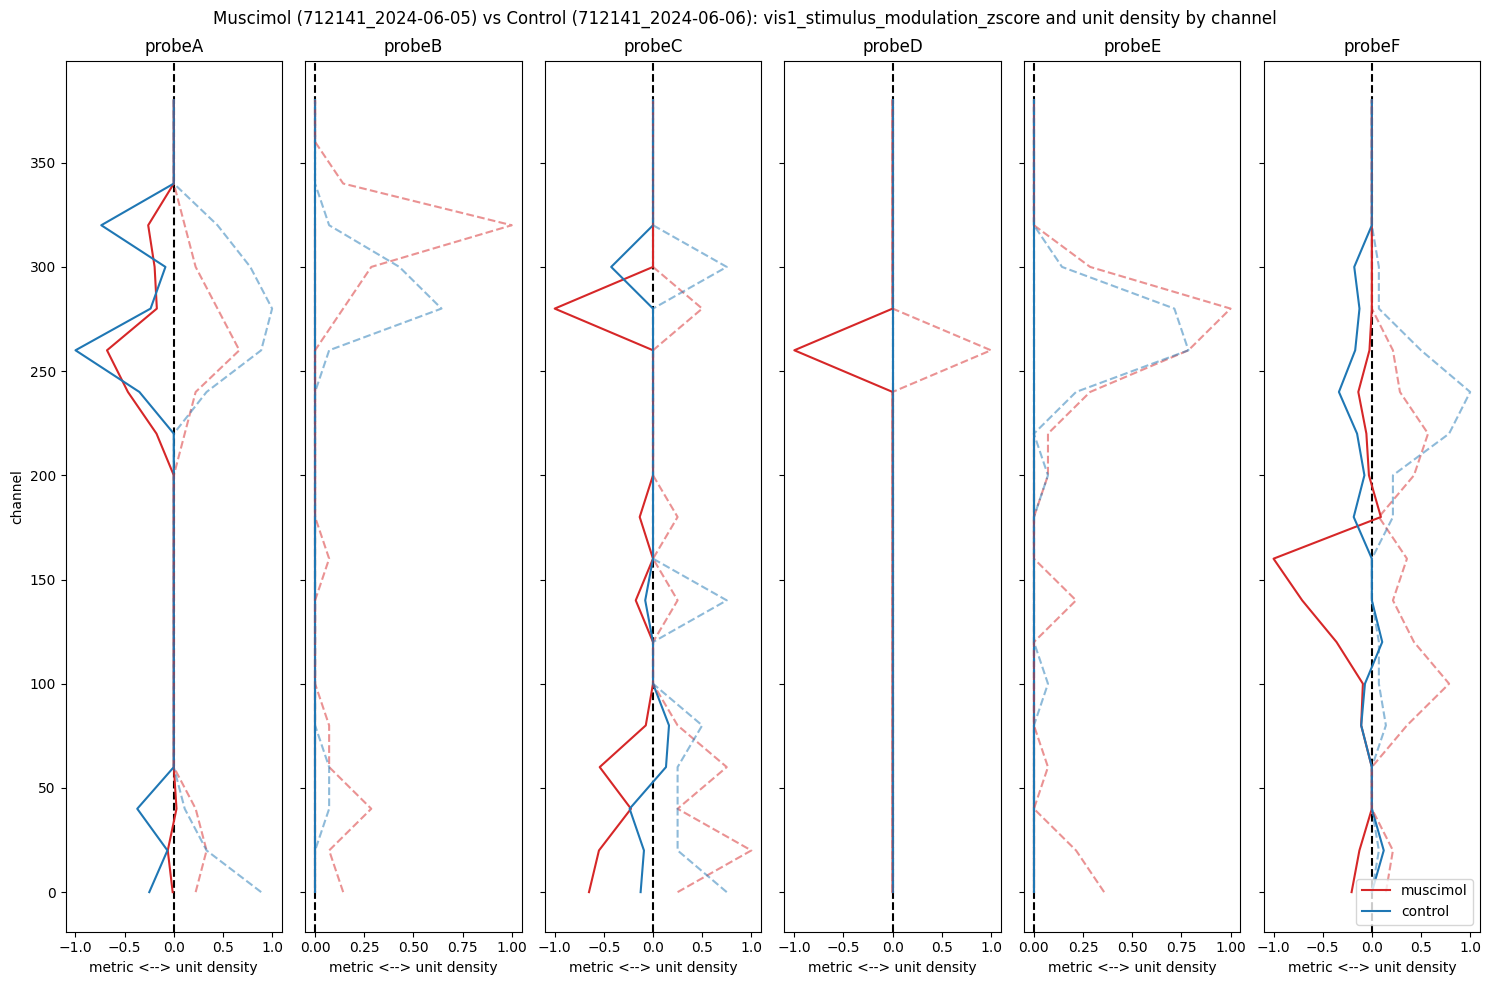

In [66]:
sel_metric='vis1_stimulus_modulation_zscore'
sel_pval='vis1_stimulus_modulation_p_value'
p_value_threshold=0.05

probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

results_by_probe = {
    'probe_name': [],
    'muscimol_metric': [],
    'control_metric': [],
    'muscimol_unit_density': [],
    'control_unit_density': [],
    'metric_max':[],
    'unit_density_max':[],
}

channel_bin_size = 20

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
    muscimol_units_probe = unit_modulation_muscimol.query('electrode_group_name==@probe_name and '+sel_pval+'<@p_value_threshold').sort_values(by='peak_channel')
    control_units_probe = unit_modulation_control.query('electrode_group_name==@probe_name and '+sel_pval+'<@p_value_threshold').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    muscimol_probe_frs = []
    control_probe_frs = []
    muscimol_probe_unit_densities = []
    control_probe_unit_densities = []

    for ch in channel_bins:
        muscimol_units_probe_ch = muscimol_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')
        control_units_probe_ch = control_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')

        if len(muscimol_units_probe_ch)==0:
            muscimol_probe_frs.append(0)
            muscimol_probe_unit_densities.append(0)
        elif len(muscimol_units_probe_ch)>0:
            muscimol_probe_frs.append(muscimol_units_probe_ch[sel_metric].mean())
            muscimol_probe_unit_densities.append(len(muscimol_units_probe_ch))
        
        if len(control_units_probe_ch)==0:
            control_probe_frs.append(0)
            control_probe_unit_densities.append(0)
        elif len(control_units_probe_ch)>0:
            control_probe_frs.append(control_units_probe_ch[sel_metric].mean())
            control_probe_unit_densities.append(len(control_units_probe_ch))

    results_by_probe['probe_name'].append(probe_name)
    results_by_probe['muscimol_metric'].append(np.array(muscimol_probe_frs))
    results_by_probe['control_metric'].append(np.array(control_probe_frs))
    results_by_probe['muscimol_unit_density'].append(np.array(muscimol_probe_unit_densities))
    results_by_probe['control_unit_density'].append(np.array(control_probe_unit_densities))
    results_by_probe['metric_max'].append(max(np.nanmax(muscimol_probe_frs),np.nanmax(control_probe_frs)))
    results_by_probe['unit_density_max'].append(max(np.nanmax(muscimol_probe_unit_densities),np.nanmax(control_probe_unit_densities)))

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

fig,ax=plt.subplots(1,6,figsize=(15,10),sharey=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].plot(-probe_data['muscimol_metric']/probe_data['metric_max'],channel_bins,label='muscimol',color='tab:red')
    ax[i].plot(-probe_data['control_metric']/probe_data['metric_max'],channel_bins,label='control',color='tab:blue')
    ax[i].plot(probe_data['muscimol_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:red',linestyle='--',alpha=0.5)
    ax[i].plot(probe_data['control_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:blue',linestyle='--',alpha=0.5)
    ax[i].set_title(probe_name)
    ax[i].set_xlabel('metric <--> unit density')
    if i==5:
        ax[i].legend()
    elif i==0:
        ax[i].set_ylabel('channel')

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): '+sel_metric+' and unit density by channel')
fig.tight_layout()
    

## plot fraction of units modulated according to some p value

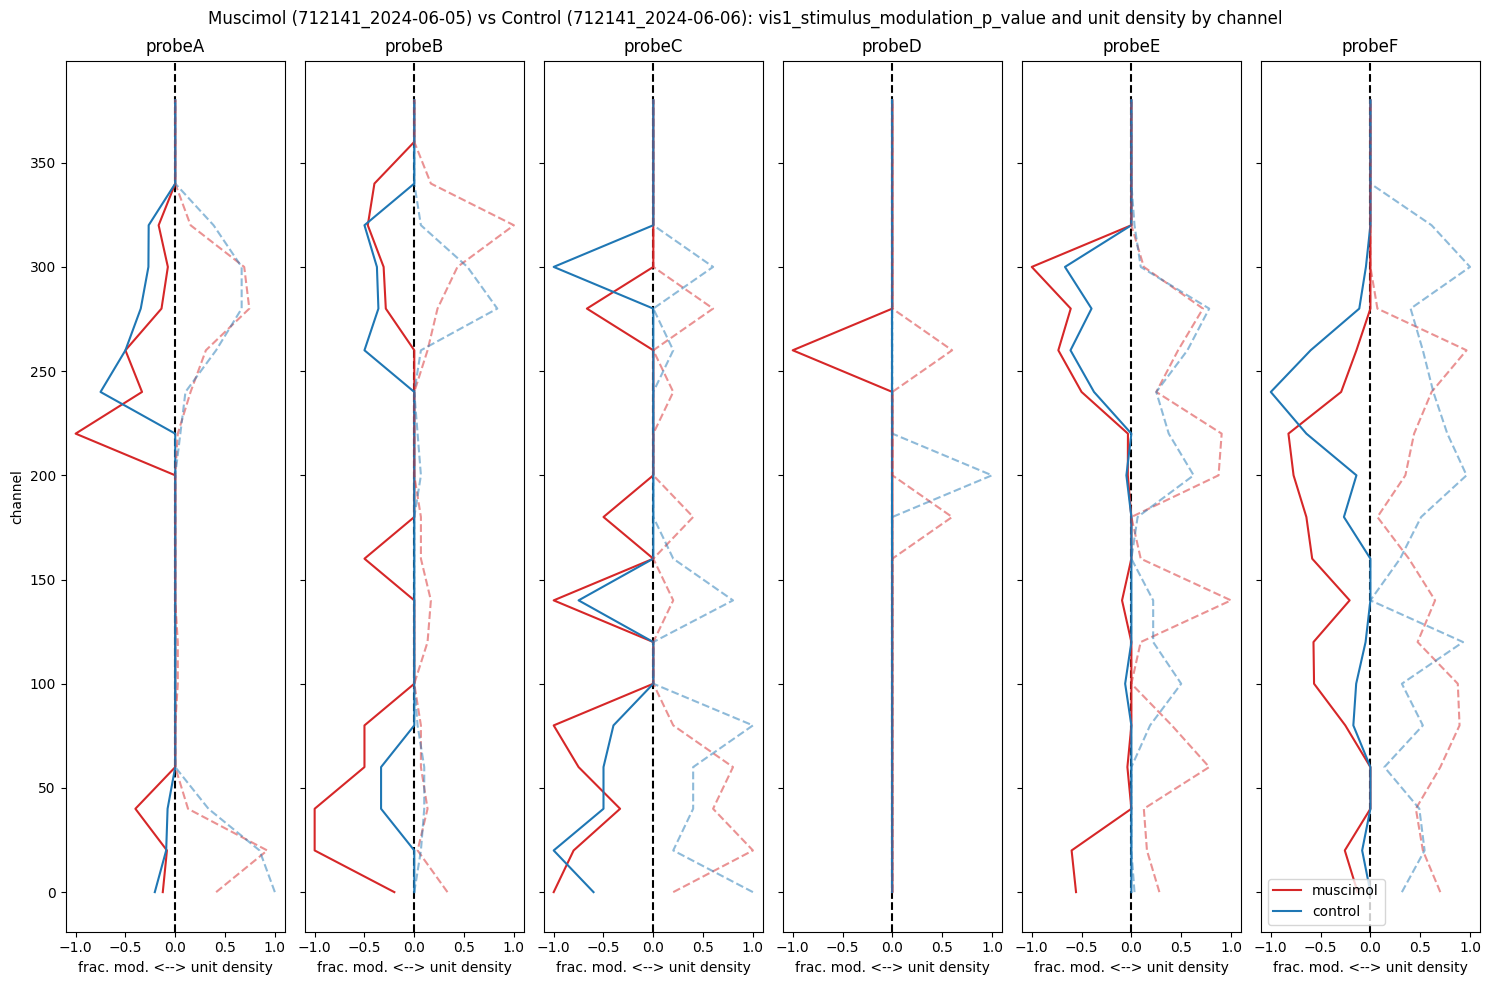

In [64]:
sel_pval='vis1_stimulus_modulation_p_value'
p_value_threshold=0.05

probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

results_by_probe = {
    'probe_name': [],
    'muscimol_metric': [],
    'control_metric': [],
    'muscimol_unit_density': [],
    'control_unit_density': [],
    'metric_max':[],
    'unit_density_max':[],
}

channel_bin_size = 20

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
    muscimol_units_probe = unit_modulation_muscimol.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = unit_modulation_control.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    muscimol_probe_frs = []
    control_probe_frs = []
    muscimol_probe_unit_densities = []
    control_probe_unit_densities = []

    for ch in channel_bins:
        muscimol_units_probe_ch = muscimol_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')
        control_units_probe_ch = control_units_probe.query('peak_channel>=@ch and peak_channel<@ch+@channel_bin_size')

        if len(muscimol_units_probe_ch)==0:
            muscimol_probe_frs.append(0)
            muscimol_probe_unit_densities.append(0)
        elif len(muscimol_units_probe_ch)>0:
            muscimol_probe_frs.append((muscimol_units_probe_ch[sel_pval]<p_value_threshold).mean())
            muscimol_probe_unit_densities.append(len(muscimol_units_probe_ch))
        
        if len(control_units_probe_ch)==0:
            control_probe_frs.append(0)
            control_probe_unit_densities.append(0)
        elif len(control_units_probe_ch)>0:
            control_probe_frs.append((control_units_probe_ch[sel_pval]<p_value_threshold).mean())
            control_probe_unit_densities.append(len(control_units_probe_ch))

    results_by_probe['probe_name'].append(probe_name)
    results_by_probe['muscimol_metric'].append(np.array(muscimol_probe_frs))
    results_by_probe['control_metric'].append(np.array(control_probe_frs))
    results_by_probe['muscimol_unit_density'].append(np.array(muscimol_probe_unit_densities))
    results_by_probe['control_unit_density'].append(np.array(control_probe_unit_densities))
    results_by_probe['metric_max'].append(max(np.nanmax(muscimol_probe_frs),np.nanmax(control_probe_frs)))
    results_by_probe['unit_density_max'].append(max(np.nanmax(muscimol_probe_unit_densities),np.nanmax(control_probe_unit_densities)))

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

fig,ax=plt.subplots(1,6,figsize=(15,10),sharey=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].plot(-probe_data['muscimol_metric']/probe_data['metric_max'],channel_bins,label='muscimol',color='tab:red')
    ax[i].plot(-probe_data['control_metric']/probe_data['metric_max'],channel_bins,label='control',color='tab:blue')
    ax[i].plot(probe_data['muscimol_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:red',linestyle='--',alpha=0.5)
    ax[i].plot(probe_data['control_unit_density']/probe_data['unit_density_max'],channel_bins,color='tab:blue',linestyle='--',alpha=0.5)
    ax[i].set_title(probe_name)
    ax[i].set_xlabel('frac. mod. <--> unit density')
    if i==5:
        ax[i].legend()
    elif i==0:
        ax[i].set_ylabel('channel')

fig.suptitle('Muscimol ('+muscimol_session_id+') vs Control ('+control_session_id+'): '+sel_pval+' and unit density by channel')
fig.tight_layout()
    

## barplots of fraction stimulus responsive units per probe

In [70]:
p_value_threshold=0.05

probe_names = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
stim_names = ['vis1','vis2','sound1','sound2']

results_by_probe = {
    'probe_name': [],
    'muscimol_vis1_frac': [],
    'control_vis1_frac': [],
    'muscimol_vis2_frac': [],
    'control_vis2_frac': [],
    'muscimol_sound1_frac': [],
    'control_sound1_frac': [],
    'muscimol_sound2_frac': [],
    'control_sound2_frac': [],
}

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for probe_name in probe_names:
    muscimol_units_probe = unit_modulation_muscimol.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')
    control_units_probe = unit_modulation_control.query('electrode_group_name==@probe_name').sort_values(by='peak_channel')

    channel_bins=np.arange(0,384,channel_bin_size)

    results_by_probe['probe_name'].append(probe_name)
    for ss in stim_names:
        results_by_probe['muscimol_'+ss+'_frac'].append((muscimol_units_probe[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())
        results_by_probe['control_'+ss+'_frac'].append((control_units_probe[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())

results_by_probe_df=pd.DataFrame(results_by_probe).set_index('probe_name')

results_by_probe_df
    

,muscimol_vis1_frac,control_vis1_frac,muscimol_vis2_frac,control_vis2_frac,muscimol_sound1_frac,control_sound1_frac,muscimol_sound2_frac,control_sound2_frac
probe_name,,,,,,,,
probeA,0.164286,0.247126,0.192857,0.218391,0.107143,0.120690,0.150000,0.178161
probeB,0.351648,0.333333,0.329670,0.333333,0.208791,0.210526,0.340659,0.140351
probeC,0.666667,0.583333,0.476190,0.333333,0.571429,0.666667,0.523810,0.583333
probeD,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
probeE,0.233831,0.222222,0.208955,0.198413,0.094527,0.095238,0.129353,0.134921
probeF,0.122318,0.087891,0.090129,0.062500,0.175966,0.136719,0.156652,0.146484


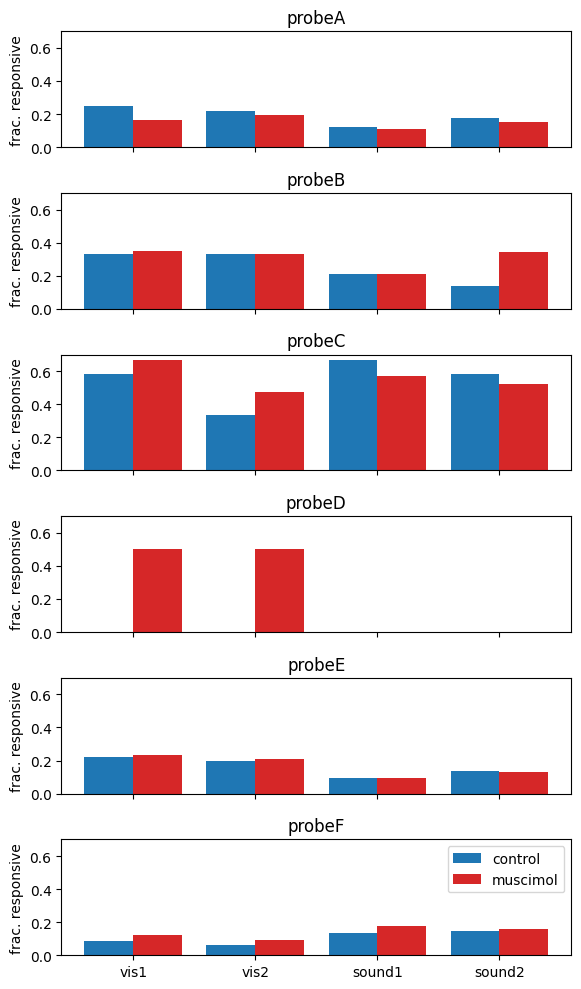

In [84]:
fig,ax=plt.subplots(6,1,figsize=(6,10),sharey=True,sharex=True)

for i,probe_name in enumerate(probe_names):
    probe_data=results_by_probe_df.loc[probe_name]

    for ss,stim_name in enumerate(stim_names):
        ax[i].bar(ss-0.2,probe_data['control_'+stim_name+'_frac'],color='tab:blue',label='control',width=0.4)
        ax[i].bar(ss+0.2,probe_data['muscimol_'+stim_name+'_frac'],color='tab:red',label='muscimol',width=0.4)
        ax[i].set_title(probe_name)
        ax[i].set_ylabel('frac. responsive')
ax[i].set_xticks(range(4))
ax[i].set_xticklabels(stim_names)
ax[i].legend(['control','muscimol'])

fig.tight_layout()

In [86]:
## barplots of fraction stimulus responsive units per area (if have area info)

p_value_threshold=0.05

if 'structure' in unit_modulation_muscimol.columns:
    areas_control = unit_modulation_muscimol['structure'].unique()
    areas_muscimol = unit_modulation_control['structure'].unique()
    areas=np.unique(np.concatenate([areas_control,areas_muscimol]))
else:
    areas=[]
    print('no area info')

stim_names = ['vis1','vis2','sound1','sound2']

results_by_area = {
    'area': [],
    'muscimol_vis1_frac': [],
    'control_vis1_frac': [],
    'muscimol_vis2_frac': [],
    'control_vis2_frac': [],
    'muscimol_sound1_frac': [],
    'control_sound1_frac': [],
    'muscimol_sound2_frac': [],
    'control_sound2_frac': [],
}

#loop through probes, make channel-wise firing rate and unit density arrays for control and muscimol

for area in areas:

    muscimol_units_area = unit_modulation_muscimol.query('structure==@area').sort_values(by='peak_channel')
    control_units_area = unit_modulation_control.query('structure==@area').sort_values(by='peak_channel')

    results_by_area['area'].append(area)
    for ss in stim_names:
        results_by_area['muscimol_'+ss+'_frac'].append((muscimol_units_area[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())
        results_by_area['control_'+ss+'_frac'].append((control_units_area[ss+'_stimulus_modulation_p_value']<p_value_threshold).mean())

results_by_area_df=pd.DataFrame(results_by_area).set_index('area')
results_by_area_df
    

no area info


,muscimol_vis1_frac,control_vis1_frac,muscimol_vis2_frac,control_vis2_frac,muscimol_sound1_frac,control_sound1_frac,muscimol_sound2_frac,control_sound2_frac
area,,,,,,,,


In [ ]:
#bar plot for every area
for aa,area in enumerate(areas):
    fig,ax=plt.subplots(1,1)
    
    area_data=results_by_probe_df.loc[area]

    for ss,stim_name in enumerate(stim_names):
        ax.bar(ss-0.2,probe_data['control_'+stim_name+'_frac'],color='tab:blue',label='control',width=0.4)
        ax.bar(ss+0.2,probe_data['muscimol_'+stim_name+'_frac'],color='tab:red',label='muscimol',width=0.4)
        ax.set_title(area)
        ax.set_ylabel('frac. responsive')
    ax.set_xticks(range(4))
    ax.set_xticklabels(stim_names)
    ax.legend(['control','muscimol'])
    fig.tight_layout()